In [14]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [15]:
df = pd.read_excel("Case Prediction Data2.xlsx")

In [16]:
df_comp = df[df["Product"] == "Compliance"]
df_comp.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,204977,Efile Acceptance,2017-01-02 05:39:00,2017-01-03 09:03:00,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03 07:17:00,2017-01-05 08:21:00,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...
6,204992,Form 2220 Line 19 dates.,2017-01-03 07:36:00,2017-01-10 09:16:00,Web,Medium,Tax Preparation,Problem / Error,Platinum,Form 2220 Line 19 dates are repeating. This is...,Compliance,Amounts,NaN,NaN,US,Answer exists KB,041335414275440,IRS e-Services and Business MeF Maintenance in...
8,204997,Corptax Upgrade File,2017-01-03 08:15:00,2017-01-03 11:36:00,Web,Medium,IT / Systems,Question / How To,Silver,provide MSI Files,Compliance,Install / Rollover,Provide Corptax Client MSI Files,NaN,NaN,Answer exists KB,NaN,NaN
10,205001,Share the MSI files for Corptax 2016.2,2017-01-03 08:24:00,2017-01-03 11:30:00,Web,Medium,IT / Systems,Question / How To,Gold,provide MSI Files,Compliance,Install / Rollover,Provide Corptax Client MSI Files,NaN,NaN,Answer exists KB,NaN,NaN


In [17]:
#dfc = df[df.Product == "Compliance"]
df_comp['Date Created'] = df_comp['Date Created'].dt.date
df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [18]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf

,Date,Case Number
Date,,
2017-01-02,2017-01-02,1
2017-01-03,2017-01-03,35
2017-01-04,2017-01-04,38
2017-01-05,2017-01-05,48
2017-01-06,2017-01-06,28
...,...,...
2022-08-11,2022-08-11,53
2022-08-12,2022-08-12,49
2022-08-13,2022-08-13,4


In [19]:
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2052 entries, 2017-01-02 to 2022-08-15
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1950 non-null   datetime64[ns]
 1   Case Number  1950 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 48.1 KB


In [20]:
newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
newdf

,Case Number
Date,
2017-01-31,1066.0
2017-02-28,1300.0
2017-03-31,2092.0
2017-04-30,1247.0
2017-05-31,1407.0
...,...
2022-04-30,914.0
2022-05-31,777.0
2022-06-30,952.0


In [21]:
month_newdf = newdf
month_newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2017-01-31 to 2022-08-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Case Number  68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [22]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 1.01
the p-value is 0.9944
the series is not stationary
----------------------------------------------------------------------------------------------------


In [23]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=10,
    max_q=10,
    m=12,
    seasonal=True,
    max_P=10, 
    max_D=10,
    max_Q=10,
    max_d=10,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='auto_arima',
)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=652.143, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=642.270, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=650.919, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=645.736, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=643.558, Time=0.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=644.076, Time=0.12 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=644.263, Time=0.20 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=640.515, Time=0.31 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=643.747, Time=0.11 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=642.151, T

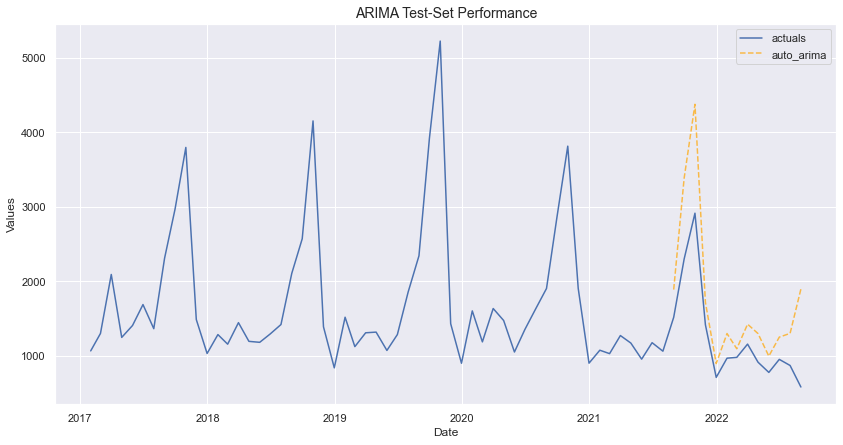

In [24]:
f.plot_test_set(ci=False,models='auto_arima')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

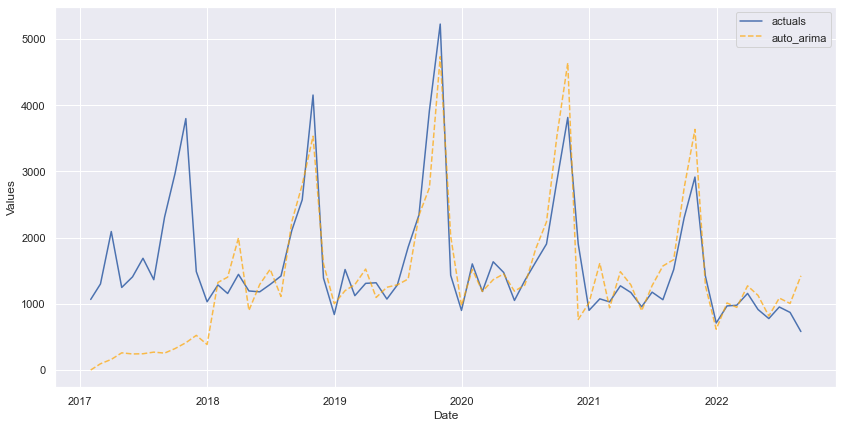

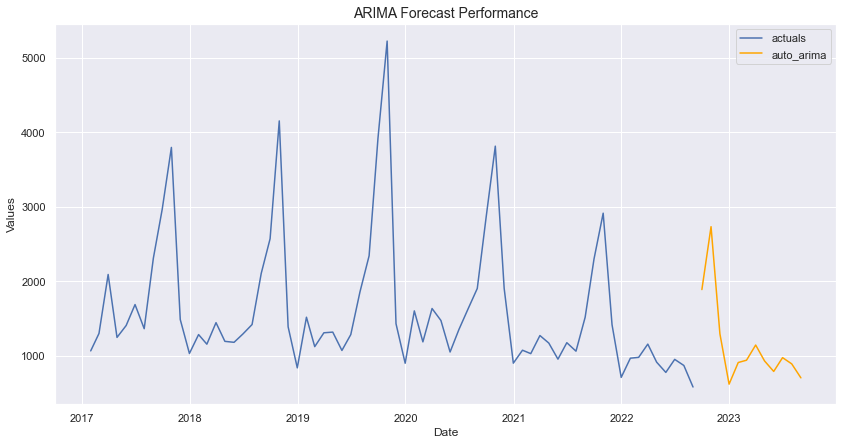

In [25]:
f.plot_fitted()
f.plot(ci=False,models='auto_arima')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [26]:
result_train = f.export_fitted_vals(model = "auto_arima")
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(result_train["Actuals"], result_train["FittedVals"]))
rms

808.7819639976585

In [29]:
result_train["Actuals"]

0     1066.0
1     1300.0
2     2092.0
3     1247.0
4     1407.0
       ...  
63     914.0
64     777.0
65     952.0
66     870.0
67     581.0
Name: Actuals, Length: 68, dtype: float64

In [42]:
print(result_train[result_train["DATE"] == "2017-08-31"])
print(result_train[result_train["DATE"] == "2018-08-31"])
print(result_train[result_train["DATE"] == "2019-08-31"])
print(result_train[result_train["DATE"] == "2020-08-31"])
print(result_train[result_train["DATE"] == "2021-08-31"])
print(result_train[result_train["DATE"] == "2022-08-31"])

        DATE  Actuals  FittedVals    Residuals
7 2017-08-31   2311.0  255.211987  2055.788013
         DATE  Actuals   FittedVals   Residuals
19 2018-08-31   2107.0  2238.858966 -131.858966
         DATE  Actuals   FittedVals  Residuals
31 2019-08-31   2343.0  2337.278865   5.721135
         DATE  Actuals   FittedVals   Residuals
43 2020-08-31   1904.0  2237.597881 -333.597881
         DATE  Actuals   FittedVals   Residuals
55 2021-08-31   1517.0  1667.884282 -150.884282
         DATE  Actuals   FittedVals   Residuals
67 2022-08-31    581.0  1422.679073 -841.679073


In [27]:
pd.options.display.max_colwidth = 100
# results = f.export(to_excel=True,
#                    excel_name='arima_results.xlsx',
#                    determine_best_by='TestSetMAPE')
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx')
pd.set_option('display.max_columns', None)
results["model_summaries"]

,ModelNickname,Estimator,Xvars,HyperParams,Scaler,Observations,Tuned,CrossValidated,DynamicallyTested,Integration,TestSetLength,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2,LastTestSetPrediction,LastTestSetActual,CILevel,CIPlusMinus,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,ValidationSetLength,ValidationMetric,ValidationMetricValue,models,weights,LevelTestSetRMSE,LevelTestSetMAPE,LevelTestSetMAE,LevelTestSetR2,LevelInSampleRMSE,LevelInSampleMAPE,LevelInSampleMAE,LevelInSampleR2,best_model
0,auto_arima,arima,None,"{'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 12), 'trend': None}",None,68,False,False,True,0,13,677.917098,0.473735,520.704109,-0.09791,1895.557101,581.0,0.95,1196.425985,808.781964,0.300714,503.783458,0.185632,None,None,None,None,None,677.917098,0.473735,520.704109,-0.09791,808.781964,0.300714,503.783458,0.185632,True


In [28]:
print("mean",newdf.mean()[0])
print("max",newdf.max()[0])
print("min",newdf.min()[0])
print("std",newdf.std()[0])
print("lvl_fcsts",results["lvl_fcsts"])

mean 1620.8235294117646
max 5226.0
min 581.0
std 902.8970609774325
lvl_fcsts          DATE   auto_arima
0  2022-09-30  1889.421139
1  2022-10-31  2733.757837
2  2022-11-30  1294.865269
3  2022-12-31   619.085756
4  2023-01-31   909.955076
5  2023-02-28   940.730385
6  2023-03-31  1144.475346
7  2023-04-30   931.090655
8  2023-05-31   790.075445
9  2023-06-30   975.325472
10 2023-07-31   891.573538
11 2023-08-31   703.875850


         DATE   auto_arima
0  2022-09-30  1889.421139
1  2022-10-31  2733.757837
2  2022-11-30  1294.865269
3  2022-12-31   619.085756
4  2023-01-31   909.955076
5  2023-02-28   940.730385
6  2023-03-31  1144.475346
7  2023-04-30   931.090655
8  2023-05-31   790.075445
9  2023-06-30   975.325472
10 2023-07-31   891.573538
11 2023-08-31   703.875850


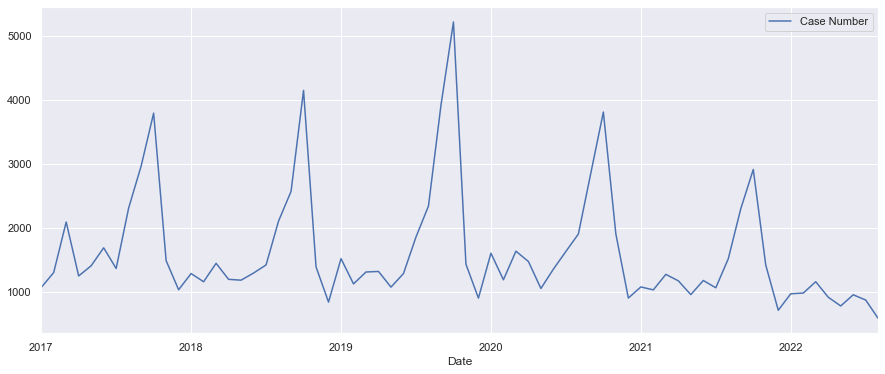

In [9]:
# Plotting number of tickets per day
month_newdf.plot(figsize=(15,6))
plt.show()

In [19]:
import itertools
# Making a list of values for p,d & q
p = d = q = range(0,5)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [20]:
import statsmodels.api as sm
# Checking the AIC values per pairs
for param in pdq:
    mod = sm.tsa.statespace.SARIMAX(month_newdf,order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) - AIC:1201.0331655274267
ARIMA(0, 0, 1) - AIC:1126.8227188243904
ARIMA(0, 0, 2) - AIC:1094.7848229266933
ARIMA(0, 0, 3) - AIC:1069.822031634407
ARIMA(0, 0, 4) - AIC:1050.5271603964804
ARIMA(0, 1, 0) - AIC:1086.5952992136035
ARIMA(0, 1, 1) - AIC:1072.0274590956203
ARIMA(0, 1, 2) - AIC:1038.2851137902044
ARIMA(0, 1, 3) - AIC:1025.0387810701245
ARIMA(0, 1, 4) - AIC:1011.5642109628578
ARIMA(0, 2, 0) - AIC:1118.6515729571556
ARIMA(0, 2, 1) - AIC:1064.4102545202431
ARIMA(0, 2, 2) - AIC:1046.3267580154104
ARIMA(0, 2, 3) - AIC:1013.9101573951882


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 4) - AIC:1000.4624133419139
ARIMA(0, 3, 0) - AIC:1166.237671417036
ARIMA(0, 3, 1) - AIC:1091.8291704059639
ARIMA(0, 3, 2) - AIC:1048.7668319463423
ARIMA(0, 3, 3) - AIC:1032.3206695790466


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 3, 4) - AIC:1006.9373896965797
ARIMA(0, 4, 0) - AIC:1219.1253024465334
ARIMA(0, 4, 1) - AIC:1135.7608831833886
ARIMA(0, 4, 2) - AIC:1081.9004141944647
ARIMA(0, 4, 3) - AIC:1062.3622056488186
ARIMA(0, 4, 4) - AIC:1032.994057109896
ARIMA(1, 0, 0) - AIC:1100.0422617191398
ARIMA(1, 0, 1) - AIC:1086.4783305238823
ARIMA(1, 0, 2) - AIC:1055.9666586931683
ARIMA(1, 0, 3) - AIC:1041.373668319932
ARIMA(1, 0, 4) - AIC:1027.467500792116
ARIMA(1, 1, 0) - AIC:1088.481441730782
ARIMA(1, 1, 1) - AIC:1060.1872298240376
ARIMA(1, 1, 2) - AIC:1039.9618701004142
ARIMA(1, 1, 3) - AIC:1027.0140453513902
ARIMA(1, 1, 4) - AIC:1003.92146503431
ARIMA(1, 2, 0) - AIC:1110.825846760039
ARIMA(1, 2, 1) - AIC:1061.0728972017905
ARIMA(1, 2, 2) - AIC:1046.1484463878946
ARIMA(1, 2, 3) - AIC:1015.7411763005969


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 4) - AIC:998.3340936931811
ARIMA(1, 3, 0) - AIC:1145.4090476810597
ARIMA(1, 3, 1) - AIC:1087.7126896829225
ARIMA(1, 3, 2) - AIC:1037.769485749063
ARIMA(1, 3, 3) - AIC:1021.726531366639
ARIMA(1, 3, 4) - AIC:1012.6171471470858
ARIMA(1, 4, 0) - AIC:1187.7353784570041
ARIMA(1, 4, 1) - AIC:1119.9519606739557
ARIMA(1, 4, 2) - AIC:1076.033989359425
ARIMA(1, 4, 3) - AIC:1050.4653631207718
ARIMA(1, 4, 4) - AIC:1006.9003689798644
ARIMA(2, 0, 0) - AIC:1086.4856148516046
ARIMA(2, 0, 1) - AIC:1085.8804003940973
ARIMA(2, 0, 2) - AIC:1057.731856674835
ARIMA(2, 0, 3) - AIC:1043.3719943467484
ARIMA(2, 0, 4) - AIC:1023.807636495817
ARIMA(2, 1, 0) - AIC:1067.63163723133
ARIMA(2, 1, 1) - AIC:1057.0738049718457
ARIMA(2, 1, 2) - AIC:1041.884739984627
ARIMA(2, 1, 3) - AIC:1028.9624267398206
ARIMA(2, 1, 4) - AIC:1005.2452405475689
ARIMA(2, 2, 0) - AIC:1080.8154371395372
ARIMA(2, 2, 1) - AIC:1056.8728213218574
ARIMA(2, 2, 2) - AIC:1036.9263756368607


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) - AIC:1017.7310932618528
ARIMA(2, 2, 4) - AIC:1012.3363976549257
ARIMA(2, 3, 0) - AIC:1104.6738072980102
ARIMA(2, 3, 1) - AIC:1069.9731367121092
ARIMA(2, 3, 2) - AIC:1039.4922617876182
ARIMA(2, 3, 3) - AIC:1023.8165298002693


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 3, 4) - AIC:1011.2020312879839
ARIMA(2, 4, 0) - AIC:1136.3523616263742
ARIMA(2, 4, 1) - AIC:1101.856997678222
ARIMA(2, 4, 2) - AIC:1045.470003953669
ARIMA(2, 4, 3) - AIC:1031.6619207128676


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 4, 4) - AIC:1004.2339229426092
ARIMA(3, 0, 0) - AIC:1067.1047582180936
ARIMA(3, 0, 1) - AIC:1069.0942026752475


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) - AIC:1059.4024990382718
ARIMA(3, 0, 3) - AIC:1045.2094733216218


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 4) - AIC:1026.477229476873
ARIMA(3, 1, 0) - AIC:1053.0576265881264
ARIMA(3, 1, 1) - AIC:1042.968669652861
ARIMA(3, 1, 2) - AIC:1043.5888486722515
ARIMA(3, 1, 3) - AIC:1026.911261403487


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4) - AIC:1009.53107307685
ARIMA(3, 2, 0) - AIC:1064.4655148033428
ARIMA(3, 2, 1) - AIC:1042.8246527022793
ARIMA(3, 2, 2) - AIC:1044.9885446846508


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 3) - AIC:1018.9204221141886


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 4) - AIC:1009.3924403475834
ARIMA(3, 3, 0) - AIC:1083.9907530953785
ARIMA(3, 3, 1) - AIC:1053.678117172828
ARIMA(3, 3, 2) - AIC:1041.3111475647029


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 3, 3) - AIC:1024.8851917934462
ARIMA(3, 3, 4) - AIC:1012.6092678236015
ARIMA(3, 4, 0) - AIC:1108.7759620048373
ARIMA(3, 4, 1) - AIC:1072.3269203557109
ARIMA(3, 4, 2) - AIC:1079.4223006467237


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 4, 3) - AIC:1034.447139098003


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 4, 4) - AIC:1005.637069928436
ARIMA(4, 0, 0) - AIC:1053.0938051411244
ARIMA(4, 0, 1) - AIC:1055.207979206361
ARIMA(4, 0, 2) - AIC:1045.646676164234


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 3) - AIC:1046.1221926980113


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 4) - AIC:1028.778193351234
ARIMA(4, 1, 0) - AIC:1034.2393896323192
ARIMA(4, 1, 1) - AIC:1027.669719286388
ARIMA(4, 1, 2) - AIC:1029.155512069858
ARIMA(4, 1, 3) - AIC:1031.1451077488086
ARIMA(4, 1, 4) - AIC:1007.1522612238334
ARIMA(4, 2, 0) - AIC:1042.6009797648464
ARIMA(4, 2, 1) - AIC:1024.1314174036568


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 2) - AIC:1017.9315383260856


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 3) - AIC:1023.0131853336793


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 4) - AIC:1000.8194842607562
ARIMA(4, 3, 0) - AIC:1060.352291502507
ARIMA(4, 3, 1) - AIC:1032.0648545119502


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 3, 2) - AIC:1024.1808225875457


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 3, 3) - AIC:1022.8147598982686


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 3, 4) - AIC:1003.3667285182378
ARIMA(4, 4, 0) - AIC:1081.7736058000512
ARIMA(4, 4, 1) - AIC:1048.3398207829207
ARIMA(4, 4, 2) - AIC:1059.1256103281767


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 4, 3) - AIC:1053.5220133952594
ARIMA(4, 4, 4) - AIC:1005.4560384895277


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#best ARIMA(1, 2, 4) - AIC:998.3340936931811

In [21]:
# Choosing the model with minimum AIC and the ARIMA Model for Time Series Forecasting
mod = sm.tsa.statespace.SARIMAX(month_newdf,order=(1,2,4))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9572      0.050    -19.285      0.000      -1.054      -0.860
ma.L1         -0.0191      1.893     -0.010      0.992      -3.729       3.691
ma.L2         -1.9021      0.132    -14.367      0.000      -2.162      -1.643
ma.L3         -0.0239      1.882     -0.013      0.990      -3.713       3.666
ma.L4          0.9895      0.151      6.554      0.000       0.694       1.285
sigma2      4.892e+05   1.01e-06   4.84e+11      0.000    4.89e+05    4.89e+05


C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
pred = results.get_prediction(start=pd.to_datetime('2022-06-30'),end=pd.to_datetime('2023-05-31'),dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.round()

2022-06-30    1156.0
2022-07-31     819.0
2022-08-31    1111.0
2022-09-30     367.0
2022-10-31     873.0
2022-11-30     748.0
2022-12-31     726.0
2023-01-31     605.0
2023-02-28     579.0
2023-03-31     462.0
2023-04-30     432.0
2023-05-31     320.0
Freq: M, Name: predicted_mean, dtype: float64

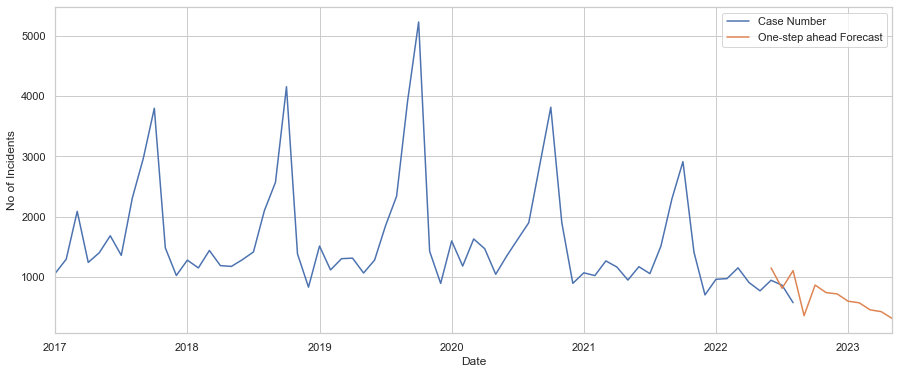

In [25]:
ax = month_newdf.plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead Forecast',figsize=(15, 6))
ax.set_xlabel('Date')
ax.set_ylabel('No of Incidents')
plt.legend()
plt.show()

# AutoARIMA

In [26]:
# Importing auto_arima 
from pmdarima.arima import auto_arima

In [27]:
#Testing for stationarity
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(month_newdf)

(0.021260346778520324, False)

In [28]:
len(month_newdf)

68

In [29]:
train = month_newdf[:60]
train

,Case Number
Date,
2017-01-31,1066.0
2017-02-28,1300.0
2017-03-31,2092.0
2017-04-30,1247.0
2017-05-31,1407.0
2017-06-30,1688.0
2017-07-31,1364.0
2017-08-31,2311.0
2017-09-30,2969.0


In [30]:
test = month_newdf[-20:]
test

,Case Number
Date,
2021-01-31,1075.0
2021-02-28,1029.0
2021-03-31,1272.0
2021-04-30,1171.0
2021-05-31,955.0
2021-06-30,1176.0
2021-07-31,1062.0
2021-08-31,1517.0
2021-09-30,2300.0


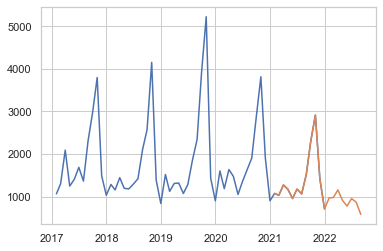

In [31]:
plt.plot(train)
plt.plot(test)

In [32]:
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=728.122, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=719.017, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=716.374, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=728.711, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=714.806, Time=0.06 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=716.471, Time=0.15 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=716.076, Time=0.15 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=716.353, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=717.915, Time=0.03 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=718.353, Time=0.22 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=714.141, Time=0.05 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=715.577, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=715.343, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[12]             

In [33]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -355.071
Date:                             Fri, 26 Aug 2022   AIC                            714.141
Time:                                     16:19:08   BIC                            717.884
Sample:                                          0   HQIC                           715.556
                                              - 60                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7120      0.122      5.851      0.000       0.474       0.951
sigma2      1.538e+05   2.12e+04      7.257      0.000    1.12e+05    1.95e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                29.49
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               3.18   Skew:                             1.02
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
arima_model.predict(n_periods = 5)

array([ 993.35702624, 1029.        , 1272.        , 1171.        ,
        955.        ])

In [34]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 20),index=test.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
Date,
2021-01-31,993.357026
2021-02-28,1029.000000
2021-03-31,1272.000000
2021-04-30,1171.000000
2021-05-31,955.000000
2021-06-30,1176.000000
2021-07-31,1062.000000
2021-08-31,1517.000000
2021-09-30,2300.000000


In [ ]:
start=pd.to_datetime('2022-06-30'),end=pd.to_datetime('2023-05-31'),dynamic=False)

In [244]:
arima_model.predict(n_periods = 20)

array([1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ,
       3906.        , 3976.        , 2166.        , 1498.        ,
       1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ])

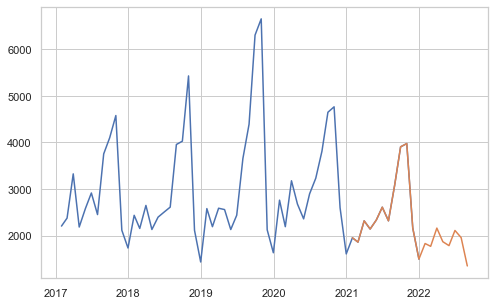

In [245]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")

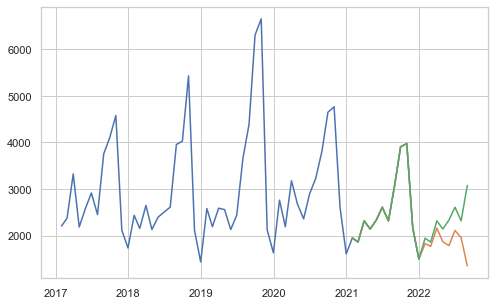

In [219]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
# plt.legend(loc = 'Left corner')
plt.show()

In [220]:
test

,Case Number
Date,
2021-01-31,1955
2021-02-28,1862
2021-03-31,2318
2021-04-30,2143
2021-05-31,2336
2021-06-30,2611
2021-07-31,2319
2021-08-31,3079
2021-09-30,3906


In [221]:
from sklearn.metrics import r2_score, rms
test['predicted_cas'] = prediction
r2_score(test['Case Number'], test['predicted_cas'])

0.5820862955758923

In [222]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(test['Case Number'], test['predicted_cas'], squared=False)
rmse

435.05610037146675

In [230]:
month_newdf

,Case Number
Date,
2017-01-31,2206
2017-02-28,2377
2017-03-31,3326
2017-04-30,2186
2017-05-31,2581
2017-06-30,2916
2017-07-31,2453
2017-08-31,3755
2017-09-30,4100


In [231]:
# Forecast
arima_model.predict(n_periods=)

array([1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ,
       3906.        , 3976.        , 2166.        , 1498.        ,
       1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ,
       3906.        , 3976.        , 2166.        , 1498.        ,
       1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ,
       3906.        , 3976.        , 2166.        , 1498.        ,
       1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ,
       3906.        , 3976.        , 2166.        , 1498.        ,
       1947.42916376, 1862.        , 2318.        , 2143.        ,
       2336.        , 2611.        , 2319.        , 3079.        ,
       3906.        , 3976.        , 2166.        , 1498.     

In [54]:
df_by_day = df1.groupby(by=df1['Date'].dt.date).count()
df_by_day

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title,Date
Date,,,,,,,,,,,,,,,,,,,
2017-01-02,4,4,4,4,4,4,4,4,4,4,4,4,1,0,3,4,3,3,4
2017-01-03,84,84,84,84,84,84,84,83,84,83,84,84,25,1,30,74,27,26,84
2017-01-04,113,113,113,113,113,113,113,113,113,113,113,113,42,6,35,110,41,39,113
2017-01-05,106,106,106,106,106,106,106,104,106,104,106,106,33,5,39,101,35,33,106
2017-01-06,87,87,87,87,87,87,87,86,87,86,87,87,35,5,31,86,24,22,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-23,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1
2017-04-24,91,91,91,91,91,91,91,88,91,88,91,91,24,0,53,90,30,27,91
2017-04-25,91,91,91,91,91,91,91,91,91,91,91,91,27,2,45,91,35,34,91


In [50]:
fig = px.line(df_by_day, x=df_by_day.index, y="Case Number")
fig.show()

In [56]:
df1.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title,Date
0,204977,Efile Acceptance,2017-01-02,2017-01-03,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017-01-02
1,204979,Oregon STAT help: Previous Case 203787 Client ...,2017-01-02,2017-01-04,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client ...,Provision,State,NaN,NaN,US.OR,Customer no longer needs assistance,NaN,NaN,2017-01-02
2,204980,Data map incorrectly pulling in values,2017-01-02,2017-01-03,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports...,Office - Excel Add-In,Import / Export,NaN,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula i...,2017-01-02
3,204981,The New Corptax Connect Website is not properl...,2017-01-02,2017-01-03,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system....,Websites,Connections (https://connect.corptax.com),Error Message,NaN,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wron...,2017-01-02
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03,2017-01-05,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...,2017-01-03


In [ ]:
co = invoice.groupby('Invoice Date')['revenue'].sum().reset_index().set_index('Invoice Date').asfreq('M')

In [63]:
df1.groupby('Date')["Case Number"].count().reset_index().set_index('Date').asfreq('M')

,Case Number
Date,
2017-01-31,105
2017-02-28,123
2017-03-31,95


In [16]:
df.groupby(['SLA']).count().reset_index()

,SLA,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,Billable Support,2,2,2,2,2,2,2,2,2,1,1,0,0,0,2,0,0
1,Client Loss,175,175,175,175,175,175,175,174,172,175,175,129,89,22,171,19,19
2,Default,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
3,Gold,7426,7426,7426,7423,7426,7426,7426,7283,7290,7424,7421,2436,339,3918,7280,1848,1756
4,Platinum,45219,45219,45219,45214,45219,45219,45219,44523,44523,45195,45174,11944,1278,31241,44490,11449,11125
5,Silver,136326,136325,136326,136288,136326,136326,136324,133576,133663,136231,136164,32600,3376,86901,134136,38572,36950


In [17]:
df.groupby(['Product']).count().reset_index()

,Product,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,Application Hosting,3440,3440,3440,3440,3440,3440,3440,3376,3440,3378,3438,2455,238,644,3424,220,216
1,Calendar,768,768,768,768,768,768,768,747,768,748,768,104,0,277,763,309,297
2,Claims,57,57,57,57,57,57,57,57,57,57,57,0,0,3,56,8,8
3,Compliance,110216,110215,110216,110203,110216,110216,110216,108047,110201,108092,110191,14250,1903,86817,109191,33451,31987
4,Data Exchange Manager,570,570,570,570,570,570,570,560,570,559,568,4,0,133,566,89,79
5,International (US),28604,28604,28604,28583,28604,28604,28602,27940,28604,27971,28589,12364,24,13984,27972,9188,8967
6,ODBC Driver - Corptax,300,300,300,300,300,300,300,278,300,277,300,0,0,151,296,56,54
7,Office - Excel Add-In,3799,3799,3799,3797,3799,3799,3799,3705,3799,3708,3795,196,95,2155,3762,1177,1143
8,Other,798,798,798,798,798,798,798,748,797,772,795,203,14,251,767,96,91
9,Partnership / S Corp / Pass-Through,9069,9069,9069,9062,9069,9069,9069,8915,9068,8922,9062,567,24,8628,8992,2191,2101


In [ ]:

total_price = grp["revenue"].groupby(level=0, group_keys=False)
oo = total_price.nlargest(3)
ax = oo.plot(kind='bar',figsize=(20,8),rot=55 )

#draw lines and titles
count = oo.groupby("District").count()
cs = np.cumsum(count)
for i in range(len(count)):
    title = count.index.values[i]
    ax.axvline(cs[i]-.5, lw=0.8, color="k")
    ax.text(cs[i]-(count[i]+1)/2., 1.02, title, ha="center",
            transform=ax.get_xaxis_transform())

# shorten xticklabels
ax.set_xticklabels([l.get_text().split(", ")[1][:-1] for l in ax.get_xticklabels()])